In [3]:
using Pkg
Pkg.update()

ipks = Pkg.installed()
pkgs = ["PyCall","RCall","RDatasets","LibCURL","JavaCall","DistributedArrays","SymPy"]
for p in pkgs
    !haskey(ipks,p) && Pkg.add(p)
end

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
  Updating git-repo `https://github.com/tonyhffong/Lint.jl.git`
  Updating git-repo `https://github.com/JuliaGraphics/Cairo.jl.git`
  Updating git-repo `https://github.com/JuliaGPU/CLFFT.jl.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


# Chapter 5 - Interoperability

In [4]:
using PyCall, PyPlot, Plots, RCall, RDatasets, JavaCall 
using DistributedArrays, SymPy, LibCURL
using Printf, Random, Distributed

## Calling other languages

In [5]:
# Simple call to a C-routine
# Can be used to set the random number seed using the system clock

systime()   = ccall((:clock,"libc"),Int32,())
randomize() = Random.seed!(systime())

randomize (generic function with 1 method)

In [6]:
systime()

113892918

In [7]:
# A 'mad' example (a*b + c) 
# The routine is called fma in library: libc
#
mad(a,b,c) = ccall((:fma,"libc"),Float64,(Float64,Float64,Float64),a,b,c)
mad(3.1,5.2,7.4)

23.520000000000003

In [8]:
# Use the system library to generate some random numbers
[ccall((:rand, "libc"), Int32, ()) for i = 1:6]

6-element Array{Int32,1}:
  776262229
  676127278
 1335185069
 1398827180
 1584930551
  540613269

In [9]:
# Call a FORTRAN routine from LAPACK to compute the dot product
# between two arrays.
# FORTRAN passes scalar arguments by reference
# Note: the vectors arepassed by reference already. 

function compute_dot(DX::Vector{Float64},DY::Vector{Float64})
    @assert length(DX) == length(DY)
    n = length(DX)
    incx = incy = 1
    dotprod = ccall((:ddot, "libLAPACK"),
                   Float64,
                   (Ptr{Int64}, Ptr{Float64}, Ptr{Int64}, 
                   Ptr{Float64}, Ptr{Int64}),
                   Ref(n), DX, Ref(incx), DY, Ref(incy))
    return dotprod
end

compute_dot (generic function with 1 method)

In [10]:
# Test it out
aa = [rand() for i = 1:1000]
bb = [rand() for i = 1:1000]
compute_dot(aa,bb)    # => Should be about 250

247.99945937751892

In [11]:
# Get the user's home directory ENV["HOME"]
ptr = ccall((:getenv, "libc"), Ptr{UInt8},(Ptr{UInt8},),"HOME")

Ptr{UInt8} @0x00007ffee20a0e4c

In [12]:
# My modules are in Julia/MyModules - put this on the LOAD PATH
#
myHome = unsafe_string(ptr)
push!(LOAD_PATH,string(myHome,"/Julia/MyModules"))

5-element Array{String,1}:
 "@"                             
 "@v#.#"                         
 "@stdlib"                       
 "/Users/malcolm/Julia/MyMods"   
 "/Users/malcolm/Julia/MyModules"

In [13]:
#= 
The system library call has a third parameter, which when set to zero will create a new variable but not overwrite an existing one.
=#
# Define the function to replace existing variable
evset(var::String, val::String) = 
     ccall((:setenv,"libc"),Clong,
           (Cstring,Cstring,Clong),var,val,1);
 
# The unset routine is quite simple
evunset(evvar::String) = 
     ccall((:unsetenv,"libc"),Clong,(Cstring,),evvar);

In [14]:
#= 
The system library call has a third parameter, which when set to zero will create a new variable but not overwrite an existing one.
=#
# Define the function to replace existing variable
evset(var::String, val::String) = 
     ccall((:setenv,"libc"),Clong,
           (Cstring,Cstring,Clong),var,val,1);
 
# The unset routine is quite simple
evunset(evvar::String) = 
     ccall((:unsetenv,"libc"),Clong,(Cstring,),evvar);


In [15]:
# Set an environment variable PACKT_HOME ...
# ... and check it
packt = evset("PACKT_HOME", string(myHome,"/PacktPub"));

ENV["PACKT_HOME"]

"/Users/malcolm/PacktPub"

In [16]:
# Now unset it, verify it is so.
evunset("PACKT_HOME");
ENV["PACKT_HOME"]


KeyError: KeyError: key "PACKT_HOME" not found

---

In [17]:
#= 

// Basel function in C

#include<stdio.h>
#include<stdlib.h>

double basel(int N) {

  double s = 0.0L;
  int i;
  double x;

  if (N < 1) return s;
  for (i = 1; i <= N; i++) {
    x = 1.0L/((double) i);
    s += x*x;
  }
  return s;
}

// Horner's method

#include<math.h>

double horner(double x, double aa[], long n) {
  long i;
  double s = aa[n-1];
  if (n > 1) { 
    for (i = n-2; i >= 0; i--) {
      s = s*x + aa[i];
    }
  }
  return s;
}

// Build a dynamic library (on OSX) as:
//
// clang -c basel.c horner.c
// libtool -dynamic basel.o horner.o -o libmyfuns.dylib  
//         -lSystem -macosx_version_min 10.13
//
// sudo cp libmyfuns.dylib /usr/local/lib

=#

run(`nm -g libmyfuns.dylib`)

0000000000000e90 T _basel
0000000000000f30 T _horner
                 U dyld_stub_binder


Process(`nm -g libmyfuns.dylib`, ProcessExited(0))

In [18]:
basel = ccall((:basel,"libmyfuns"),Float64,(Int64,),10000000)

1.6449339668472596

In [19]:
# Time the function for 10^7 loops
@elapsed ccall((:basel,"libmyfuns"),Float64,(Int64,),10000000)

0.194820469

In [20]:
# C version of Horners method
# Note use of Cdouble, Clong rather than Float64, Int64 etc.
#
x = 2.1;
aa = [1.0, 2.0, 3.0, 4.0, 5.0];

ccall((:horner,"libmyfuns.dylib"),Cdouble,
              (Cdouble,Ptr{Cdouble},Clong),x,aa,length(aa))

152.71450000000002

### Embedding C in Julia

In [21]:
# Compute PI in 'C', usual Monte Carlo method
# We ca put the C code in a multiline string

C_code = """
#include <stddef.h>
#include <stdlib.h>

double c_pi(long n) {
    long k = 0L;
    float rmax = (float) RAND_MAX;
    for (long i = 0L; i < n; i++) {
        float x = ((float) rand())/rmax;
        float y = ((float) rand())/rmax;
        if ((x*x + y*y) < 1.0) {
          k++;
        }
    }
    return 4.0*((double) k)/((double) n);
}
"""

# Get a temporary name to create a library
const Clib = tempname()   # ... make a temporary file

"/var/folders/ns/9qt1mg2j7ldgnp5b1qt0fszr0000gn/T/juliadpw5iW"

In [22]:
# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):
using Libdl
tmplib = string(Clib,".",dlext)
open(`gcc -fPIC -O3 -msse3 -xc -shared -o $tmplib -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_pi(N::Int64) = ccall(("c_pi", Clib), Float64, (Clong,), N)

c_pi (generic function with 1 method)

In [23]:
using Random
randomize();
c_pi(1000000)

3.141856

### Using the Julia API

In [ ]:
C_Code = """
include <julia.h>
#include <stdio.h>
#include <math.h>

// Only define this once if in an executable ...
// (i.e. not in a shared library) ...
// ... and if we want the fastest code.
JULIA_DEFINE_FAST_TLS()

int main(int argc, char *argv[])
{
/* required: setup the Julia context */
  jl_init();

/* run Julia commands */
  jl_function_t *fnc1 = jl_get_function(jl_base_module, "exp");
  jl_function_t *fnc2 = jl_get_function(jl_base_module, "sin");
  jl_value_t* arg1 = jl_box_float64(-0.3);
  jl_value_t* arg2 = jl_box_float64(3.0);
  jl_value_t* ret1 = jl_call1(fnc1, arg1);
  jl_value_t* ret2 = jl_call1(fnc2, arg2);

/* unbox and setup final result */
  double retD1 = jl_unbox_float64(ret1);
  double retD2 = jl_unbox_float64(ret2);
  double retD3 = retD1*retD2;
  printf("sin(3.0)*exp(-0.3) from Julia API: %e\n", retD3); 
  fflush(stdout);

/* Allow Julia time to cleanup pending write requests etc. */
  jl_atexit_hook(0);
  return 0;
}
""";

In [ ]:
# Can use a nice command script in 'share/julia/julia-config.jl
./julia-config.jl 
usage: julia-config [--cflags | --ldflags |
                     --ldlibs | --allflags]

In [ ]:
JULIA_HOME = \
/Applications/Julia-1.1.app/Contents/Resources/julia; export JULIA_HOME

ls $JULIA_HOME
LICENSE.md bin etc include lib share


In [ ]:
cc jltest.c -o jltest -std=gnu99 \
      -I$JULIA_HOME/include/julia \
      -DJULIA_ENABLE_THREADING=1 -fPIC \
      -L$JULIA_HOME/lib \
      -Wl,-rpath,$JULIA_HOME/lib \
      -Wl,-rpath,$JULIA_HOME/lib/julia \
      -ljulia

./jltest
sin(3.0)*exp(-0.3) from Julia API: 1.045443e-01

### An example using LibCURL

In [24]:
using LibCURL
url = "http://LondonJulia.org/mastering-julia.html"

"http://LondonJulia.org/mastering-julia.html"

In [25]:
# init a curl handle
curl = curl_easy_init();

# set the URL and request to follow redirects
curl_easy_setopt(curl, CURLOPT_URL, url);
curl_easy_setopt(curl, CURLOPT_FOLLOWLOCATION, 1);

In [26]:
# setup the callback function to recv data
function curl_write_cb(curlbuf::Ptr{Nothing}, s::Csize_t, n::Csize_t, p_ctxt::Ptr{Nothing})
  sz = s * n
  data = Array{UInt8}(undef,sz)
  ccall(:memcpy, Ptr{Nothing}, (Ptr{Nothing}, Ptr{Nothing}, UInt64), data, curlbuf, sz)
  println(String(data))
  sz::Csize_t
end

curl_write_cb (generic function with 1 method)

In [27]:
c_curl_write_cb = 
  @cfunction(curl_write_cb, Csize_t, 
             (Ptr{Nothing}, Csize_t, Csize_t, Ptr{Nothing}));
curl_easy_setopt(curl, CURLOPT_WRITEFUNCTION, c_curl_write_cb);

In [28]:
# execute the query
res = curl_easy_perform(curl)

<!DOCTYPE html>
<html>
<head>
<title>Mastering Julia Cover</title>
<style type="text/css">
h2 { font-family: verdana; font-size: 150%;}
p  { font-family: courier; font-size: 120%; }
</style>
</head>
<body>
<h2>Mastering Julia</h2>
<p><i>Malcolm Sherrington (2015)</i></p>
<img src="images/mastering-julia.jpg" alt="Mastering Julia" />
<p>&nbsp;</p>
</body>
</html>


0x00000000

In [29]:
println("curl url exec response : ", res)

curl url exec response : 0


In [30]:
# retrieve HTTP code
http_code = Array{Clong}(undef,1)
curl_easy_getinfo(curl, CURLINFO_RESPONSE_CODE, http_code)
println("httpcode : ", http_code)

httpcode : [200]


In [31]:
# release handle
curl_easy_cleanup(curl)

---

### Calling Python

In [32]:
using PyCall

In [33]:
@pyimport numpy.random as nr
aa = nr.rand(4,5)      # aa is a Julia array generated with Numpy

┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:407
└ @ PyCall /Users/malcolm/.julia/packages/PyCall/ttONZ/src/PyCall.jl:407


4×5 Array{Float64,2}:
 0.322373  0.118397  0.845277  0.420335  0.297157
 0.821324  0.243797  0.718591  0.308151  0.486081
 0.13484   0.466394  0.288492  0.440466  0.254784
 0.598403  0.366719  0.445587  0.939961  0.415684

In [34]:
# So an array slice has no overhead(i.e. in Julia)
aa[2:3,2:3]

2×2 Array{Float64,2}:
 0.243797  0.718591
 0.466394  0.288492

In [35]:
# Using the SciPy package
@pyimport scipy.optimize as so
so.ridder(x -> x*cos(x),1,π)

1.5707963267958964

In [36]:
@pyimport scipy.integrate as si
si.quad(x -> x*sin(x),1,π)

(2.840423974650036, 3.153504096353772e-14)

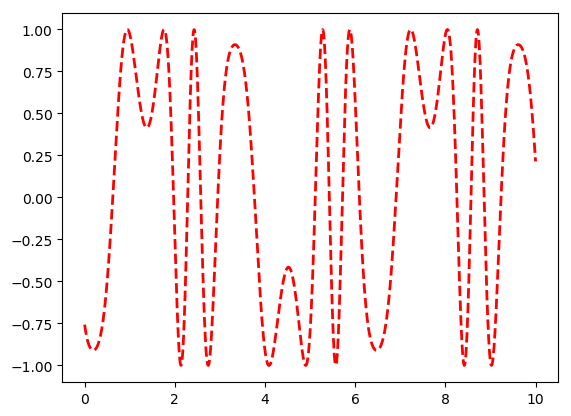

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x15536786a0>

In [37]:
# ... and plotting with matplotlib
# @pyimport matplotlib.pyplot as plt
x = range(0,stop=10,length=1000); 
y = sin.(3*x + 4*cos.(2*x));

plt.plot(x, y, color="red", linewidth=2.0, linestyle="--")

In [38]:
plt.show()

---

### SymPy


In [39]:
using SymPy

In [40]:
# We need to work with a special type: a symbol (in the SymPy sense)
u = symbols("u")
x = symbols("x", real=true)
y1, y2 = symbols("y1, y2", positive=true)
alpha = symbols("alpha", integer=true, positive=true)

typeof(x)

Sym

In [41]:
# We can solve some algebraic equations
solve(u^2 + 1)

2-element Array{Sym,1}:
 -I
  I

In [42]:
# Perform functional expansions
p = expand(prod([sin(x^(-i)) for i in 1.0:1.0:5.0]))

   ⎛ -5.0⎞    ⎛ -4.0⎞    ⎛ -3.0⎞    ⎛ -2.0⎞    ⎛ -1.0⎞
sin⎝x    ⎠⋅sin⎝x    ⎠⋅sin⎝x    ⎠⋅sin⎝x    ⎠⋅sin⎝x    ⎠

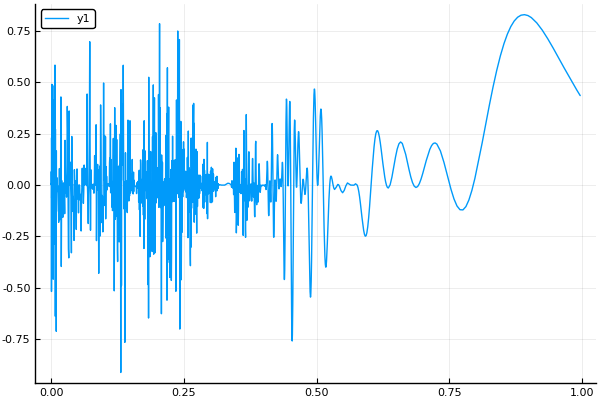

In [43]:
# SymPy can use the Plot API to display graphs
x = symbols("x")
using Plots
pyplot()

Plots.plot(p, 0.0, 1.0)

In [44]:
# For a more complex example, which we have seen before, ...
# ... the sum of the Basel series
#
i, n = symbols("i, n")
sn = sum(1/i^2, (i, 1, n))

    1    1 
1 + ── + ──
     2    2
    n    i 

In [45]:
limit(sn, n, oo)

 2    
i  + 1
──────
   2  
  i   

In [46]:
# An initial valued problem
#
y = SymFunction("y")
a, x = symbols("a,x")
eqn = y'(x) - 3*x*y(x) - 1

            d           
-3⋅x⋅y(x) + ──(y(x)) - 1
            dx          

## Calling R

In [47]:
using RCall

In [48]:
# Perform a t-test on a set of 1000 normally distributed variates
#
x = randn(1000);
R"t.test($x)"

RObject{VecSxp}

	One Sample t-test

data:  `#JL`$x
t = 0.10918, df = 999, p-value = 0.9131
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.05866040  0.06557244
sample estimates:
  mean of x 
0.003456019 



In [49]:
# Optimise function using BFGS (Broyden–Fletcher–Goldfarb–Shannon§§§§§≠±±) algorithm
#
f(x) = 10*sin(0.3*x)*sin(1.3*x^2) + 0.00001*x^4 + 0.2*x + 40
R"optim(0, $(x -> f(x)), method='BFGS')"

RObject{VecSxp}
$par
[1] -6.685958

$value
[1] 29.61426

$counts
function gradient 
      28        8 

$convergence
[1] 0

$message
NULL



In [50]:
@rlibrary MASS

In [51]:
 geyser = rcopy(R"MASS::geyser")  

,waiting,duration
,Float64,Float64
1,80.0,4.01667
2,71.0,2.15
3,57.0,4.0
4,80.0,4.0
5,75.0,4.0
6,77.0,2.0
7,60.0,4.38333
8,86.0,4.28333
9,77.0,2.03333


In [52]:
round(sum(geyser[:waiting])/sum(geyser[:duration]),digits=5)

20.8952

In [53]:
rcall(:summary, geyser[:waiting])

RObject{RealSxp}
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  43.00   59.00   76.00   72.31   83.00  108.00 


In [54]:
rcall(:summary, geyser[:duration])

RObject{RealSxp}
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8333  2.0000  4.0000  3.4608  4.3833  5.4500 


In [3]:
# Use R to grab some financial data
# and plot it.
using RCall

R"""
library(data.table)
library(scales)
library(ggplot2)
        
link <- "Files/fin_data.csv"
dt <- data.table(read.csv(link))
dt[, date := as.Date(date)]
        
# create indexed values
dt[, idx_price := price/price[1], by = ticker]
"""

RObject{VecSxp}


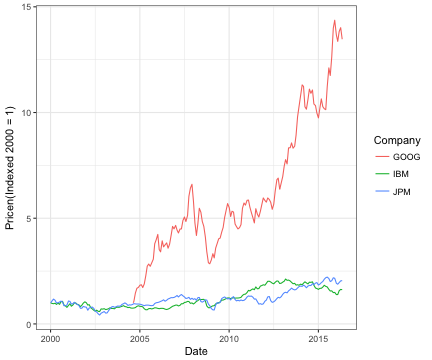

RObject{VecSxp}


In [4]:
R"""
ggplot(dt, aes(x = date, y = idx_price, color = ticker)) + 
       geom_line() + theme_bw() + 
       xlab("Date") + ylab("Pricen(Indexed 2000 = 1)") + 
       scale_color_discrete(name = "Company")
"""

---

### Calling Java

In [5]:
using JavaCall
JavaCall.init(["-Xmx128M"])     # Initialise and ask for additional memory

#=
 May set the current directory as the classpath in the init() call
 viz. JavaCall.init(["-Xmx128M -Djava.class.path=$(@__DIR__)"])

 Ignore the (possible) segmentation fault
 See: http://juliainterop.github.io/JavaCall.jl/faq.html

 This works inside in a Notebook, despite the segmentation fault (on OSX)
 In the REPL, julia may nned to be started with a --handle-signals=no
 option to disable Julia's signal handler. 
 [This may cause issues with handling ^C in Julia programs.]
=#


signal (11): Segmentation fault: 11
in expression starting at /Users/malcolm/.julia/packages/IJulia/gI2uA/src/kernel.jl:52
unknown function (ip: 0x1385012b3)
Allocations: 46228181 (Pool: 46219308; Big: 8873); GC: 100


In [ ]:
#=

 Ignore the Segmentation fault on OSX, as explained above

=#

In [6]:
# JavaCall needs to modify Julia variables before using them in functions  
a = JString("Hello, Blue Eyes")

JavaObject{Symbol("java.lang.String")}(Ptr{Nothing} @0x00007fb922a43350)

In [7]:
# The JString as a single field (:ptr)
fieldnames(typeof(a))

(:ptr,)

In [8]:
a.ptr

Ptr{Nothing} @0x00007fb922a43350

In [9]:
# The pointer can now be used in a Java function

b = ccall(JavaCall.jnifunc.GetStringUTFChars, Ptr{UInt8},
            (Ptr{JavaCall.JNIEnv}, Ptr{Nothing}, Ptr{Nothing}),
                                 JavaCall.penv, a.ptr, C_NULL)

unsafe_string(b)

"Hello, Blue Eyes"

In [10]:
# Similar to PyCall, we can use JavaCall to perform some mathematics

jlm = @jimport "java.lang.Math"
jcall(jlm, "exp", jdouble, (jdouble,), pi*pi/6.0)

5.180668317897116

In [11]:
# ... and to access Internet libraries
jnu = @jimport java.net.URL
jurl = jnu((JString,), "http://LondonJulia.org/mastering-julia.html")
www = jcall(jurl, "getHost", JString,())

"LondonJulia.org"

In [12]:
# Finally let's import the ArrayList class, ...
# ... define an instance and add some items to it
JArrayList = @jimport(java.util.ArrayList)
a = JArrayList(())
jcall(a, "add", jboolean, (JObject,), "'Twas ")
jcall(a, "add", jboolean, (JObject,), "brillig, ")
jcall(a, "add", jboolean, (JObject,), "and ")
jcall(a, "add", jboolean, (JObject,), "the ")
jcall(a, "add", jboolean, (JObject,), "slithy ")
jcall(a, "add", jboolean, (JObject,), "toves,")

# Now iterate thru' the array and push it on a Julia array ...
# ... converting the bit type to an (unsafe) string.
#
t = Array{Any, 1}()
for i in JavaCall.iterator(a)
  push!(t, unsafe_string(i))
end

# Evaluate the  result.
join(t)


"'Twas brillig, and the slithy toves,"

---

## O/S commands and Pipelines

In [13]:
# Get a webpage using curl or wget
# Notice the backticks
# First check that curl (or wget) is available, ...
# ... otherwise you will need to install it. 
#
cmd = `which curl`
typeof(cmd)

Cmd

In [14]:
#=
 Commands now need to be run, i.e. they are not executed immediately
 Since commands run as separate tasks, it is usually preferable to 
 suppress the output of the run() function

 The task output will goto STDOUT (by default) but can be captured
 and used by the Julia program
=#
run(cmd)

/Users/malcolm/anaconda/bin/curl


Process(`which curl`, ProcessExited(0))

In [15]:
# We can use curl to get the webpage ...
# .. and can do it in one step
proc = run(`curl "http://LondonJulia.org/mastering-julia.html"`);

<!DOCTYPE html>
<html>
<head>
<title>Mastering Julia Cover</title>
<style type="text/css">
h2 { font-family: verdana; font-size: 150%;}
p  { font-family: courier; font-size: 120%; }
</style>
</head>
<body>
<h2>Mastering Julia</h2>
<p><i>Malcolm Sherrington (2015)</i></p>
<img src="images/mastering-julia.jpg" alt="Mastering Julia" />
<p>&nbsp;</p>
</body>
</html>

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   364  100   364    0     0   5200      0 --:--:-- --:--:-- --:--:--  5200


In [ ]:
# Look at Base:process.jl for definition of Julia process structure

#=
mutable struct Process <: AbstractPipe
    cmd::Cmd
    handle::Ptr{Cvoid}
    in::IO
    out::IO
    err::IO
    exitcode::Int64
    termsignal::Int32
    exitnotify::Condition
    closenotify::Condition
    . . .
    . . .
end
=#

proc.exitcode   # Zero is normal exit status

In [16]:
cd(string(ENV["HOME"],"/PacktPub/Datasets/Alice"))
pwd()  

# Needs to be where the chapter 5 files are and may be changed depending 
# on the user's setup

"/Users/malcolm/PacktPub/Datasets/Alice"

In [17]:
# Define a function to use the wordcount ('wc') utility
wc(f) = isfile(f) && run(`wc $f`)

wc (generic function with 1 method)

In [18]:
# Count the number of occurences of 'beaver" in the Hunting of the Snark,
# piping the output to a file

txtfile = "hunting-the-snark.txt";
logfile = "hunting-the-snark.log";

run(pipeline(`grep -i beaver $txtfile`,stdout=logfile));

In [19]:
wc(logfile);

      19     138     821 hunting-the-snark.log


In [20]:
# Do this again for the bellman but append the output to the log file.

run(pipeline(`grep -i bellman $txtfile`,stdout=logfile,append=true));
wc(logfile);

      49     371    2202 hunting-the-snark.log


In [21]:
#=
  Do we have any lines with both beaver and bellman
  Note in the 'grep' we ignored case (-i) but will stiil find
  plurals and possibly punctuation, viz.: Beavers.
  I'll attend to this later.
=#
run(pipeline(`grep -bellman $txtfile`,`grep -i beaver`));

2523:He could only kill Beavers. The Bellman looked scared,


---

### A useful utility to find large files

In [ ]:
function ftop(dir=".", nf=20)
  @assert nf > 0
  efind =  `find $dir -type f -iname "*" -exec du -sh "{}" + `
  try
    run(pipeline(efind,`sort -rh`,`head -$nf`))
    println("Done.")
  catch
    println("No files found.")
  end
end

In [ ]:
dd = ENV["HOME"]*"/PacktPub"
ftop(dd,10)


In [ ]:
# Code to run from the command line
# Source: ftop-main.jl

#=
# See if any arguments have been passed
# If so process them otherwise set the defaults
#
nargs = size(ARGS)[1]
if nargs > 2
  println("usage: ftop [dir [nfiles]]")
  exit(-1)
else
  dir = (nargs > 0) ? ARGS[1] : "."
  nf  = (nargs > 1) ? ARGS[2] : 20
end

# Main 'find' command
efind =  `find $dir -type f -iname "*" -exec du -sh "{}" + `

# Get and print the directory to be searched
cwd = string(pwd(),"/",dir)
println("Directory: $cwd")

# Then run the pipeline
try
  run(pipeline(efind,`sort -rh`,`head -$nf`))
  println("Done.")
catch
  println("No files found.")
end
=#



---

## Perl One Liners

In [22]:
#=
 Perl has falled out of fashion with the rise of Python but still
 but still remains one of the best methods for data munging.

  Unix distros and OSX (normally) have Perl avaiable but in Windows
  it needs to installed and on the executable path.

  Julia performance in handling string is not one of its greatest strenghs
  so munging large files can successfully done using Perl.

  Note: 
  Julia has introduced an analytical engine (JuliaDB) to tackle the
  processing of large datasets, employing some clever memory management
  techniques and we will discuss this in the next chapter

=#

# On OSX and Linux, there is a word list in /usr/share/dict
# This command outputs an palindromes of 6 or more letters
# (I am not try to teach Perl but most of the syntax is easily followed)
cmd = `perl -nle 'print if $_ eq reverse && length > 5' /usr/share/dict/words`
run(cmd);

deedeed
degged
hallah
kakkak
murdrum
redder
repaper
retter
reviver
rotator
sooloos
tebbet
terret


In [ ]:
# Here is a work-around using temporary files
# Capture the output of palindrome command and 

tmpfile = mktemp(tempdir());   # Alternative to tempfile() call
cmd = `perl -nle 'print if $_ eq reverse && length > 5' /usr/share/dict/words`
run(pipeline(cmd; stdout=tmpfile)); 

In [ ]:
dmp = read(tmpfile);
run(`rm -f $tmpfile`);  # Good idea to remove the temporary file

# Dump is a byte array
(eltype(dmp),length(dmp))

In [ ]:
# Convert the byte array to a string
# Note the carriage returns 
ss = String(dmp)

In [ ]:
# Remove the trailing \n and then split into words
sa = split(chomp(ss),"\n")
typeof(sa)

---

In [24]:
# PERL is good (and quick) for processing strings
# A large pipeline (probably not on Windows)
# Get top 10 words in the Hunting of the Snark, ignoring blank lines
# I'll leave it the the reader ti work out what the command do!
#
cd(ENV["HOME"]*"/PacktPub/Datasets/Alice")

fl = "hunting-the-snark.txt";
c1 = `perl -pne 'tr/[A-Z]/[a-z]/' $(fl)`;
c2 = `perl -ne 'print join("\n", split(/\s+/,$_));print("\n")'`;

run(pipeline(c1,c2,`sort`,`grep -ve '^$'`,`uniq -c`,`sort -rn`,`head -10`));

 299 the
 153 and
 123 a
 105 to
  91 it
  82 with
  76 of
  76 in
  75 he
  69 that


In [25]:
# Look at occurences of Bellman
#
run(pipeline(c1,c2,`sort`,`grep -ve '^$'`,`uniq -c`,`sort -rn`,`grep -i Bellman`));

  25 bellman
   4 bellman,
   1 bellman's


In [26]:
# Suspect there is a problem with punctuation marks
# Here are the bottom 10 words.
#
run(pipeline(c1,c2,`sort`,`grep -ve '^$'`,`uniq -c`,`sort -rn`,`tail -10`));

   1 'fritter
   1 'friends,
   1 'for,
   1 'dunce.')
   1 'come,
   1 'candle-ends,'
   1 'but,
   1 'be
   1 'a
   1 '-jum!'


In [27]:
# So we need to add an extra task in the pipe
# If we do this through a function we can pass any poem
#
function munge(fl)
  c1 = `perl -pne 'tr/[A-Z]/[a-z]/' $(fl)`;
  c2 = `perl -pne 's/()[[:punct:]]//g'`;
  c3 = `perl -ne 'print join("\n", split(/\s+/,$_));print("\n")'`
  c4 = `grep -ve '^$'`
  read(pipeline(c1,c2,c3,`sort`,c4,`uniq -c`,`sort -rn` ))
end

munge (generic function with 1 method)

In [28]:
text = munge("hunting-the-snark.txt");
(eltype(text),length(text))

(UInt8, 15889)

In [29]:
lines = split(String(text),"\n")
n = length(lines)

1323

In [30]:
s2 = [split(lines[i]) for i = n-9:n]

10-element Array{Array{SubString{String},1},1}:
 ["1", "aided"]       
 ["1", "aghast"]      
 ["1", "ages"]        
 ["1", "affectionate"]
 ["1", "advice"]      
 ["1", "additional"]  
 ["1", "aboard"]      
 ["1", "able"]        
 ["1", "abetted"]     
 []                   

In [31]:
pwd()

"/Users/malcolm/PacktPub/Datasets/Alice"

In [33]:
# We can use the process in/out channels to capture the I/O
# (rev.pl is in the parent folder)
jabber = "jabberwocky.txt";
proc = open(`rev.pl $jabber`,"r+");
close(proc.in);

In [34]:
proc.out

Pipe(RawFD(0xffffffff) closed => RawFD(0x0000003a) open, 0 bytes waiting)

In [35]:
poem = readlines(proc.out);
close(proc.out)

In [36]:
poem

34-element Array{String,1}:
 "sevot yhtils eht dna ,gillirb sawT'"      
 ":ebaw eht ni elbmig dna eryg diD"         
 ",sevogorob eht erew ysmim llA"            
 ".ebargtuo shtar emom eht dnA"             
 ""                                         
 "!nos ym ,kcowrebbaJ eht eraweB'"          
 "!hctac taht swalc eht ,etib taht swaj ehT"
 "nuhs dna ,drib bujbuJ eht eraweB"         
 "'!hctansrednaB suoimurf ehT"              
 ""                                         
 ":dnah ni drows laprov sih koot eH"        
 "-- thguos eh eof emoxnam eht emit gnoL"   
 ",eert mutmuT eht yb eh detser oS"         
 ⋮                                          
 "daeh sti htiw dna ,daed ti tfel eH"       
 ".kcab gnihpmulag tnew eH"                 
 ""                                         
 "?kcowrebbaJ eht nials uoht tsah dnA'"     
 "!yob hsimaeb ym ,smra ym ot emoC"         
 "'!yallaC !hoollaC !yad suojbarf hO"       
 ".yoj sih ni deltrohc eH"                  
 ""                        

---

In [37]:
# We are not limited to just Perl(5)
# Get Perl6 from https://rakudo.org/files/
# Put it on the path OR setup a symbolic link to the binary: 
# viz: perl6 -> /Applications/Rakudo/bin/perl6

run(`which perl6`);

/Users/malcolm/bin/perl6


In [38]:
# Use Perl6 to find the line of the greatest length
#
run(`perl6 -e 'my $max=""; 
      for (lines) {$max = $_ if .chars > $max.chars};
      END { $max.say }' hunting-the-snark.txt`);

'You must know ---' said the Judge: but the Snark exclaimed 'Fudge!'


---

In [39]:
# These techniques can be used with any command processor
# This turns all characters after 40th spot to RED
#
run(`ruby -e 'w = $*.shift; $<.each { |l| puts "#{l}\e[31m#{l.chop!.slice!(w.to_i..-1)}\e[0m" }' 40 hunting-the-snark.txt`);


Fit the First
THE LANDING

'Just the place for a Snark!' the Bellman cried,
As he landed his crew with care;
Supporting each man on the top of the tide
By a finger entwined in his hair.

'Just the place for a Snark! I have said it twice:
That alone should encourage the crew.
Just the place for a Snark! I have said it thrice:
What i tell you three times is true.'

The crew was complete: it included a Boots--
A maker of Bonnets and Hoods--
A Barrister, brought to arrange their disputes--
And a Broker, to value their goods.

A Billiard-maker, whose skill was immense,
Might perhaps have won more than his share--
But a Banker, engaged at enormous expense,
Had the whole of their cash in his care.

There was also a Beaver, that paced on the deck,
Or would sit making lace in the bow:
And had often (the Bellman said) saved them from wreck,
Though none of the sailors knew how.

There was one who was famed for the number of things
He forgot when he entered the ship:
His umbrella, his watch, all h

'Should we meet with a Jubjub, that desperate bird,
We shall need all our strength for the job!'


Fit the Fifth
THE BEAVER'S LESSON

They sought it with thimbles, they sought it with care;
They pursued it with forks and hope;
They threatened its life with a railway-share;
They charmed it with smiles and soap.

Then the Butcher contrived an ingenious plan
For making a separate sally;
And fixed on a spot unfrequented by man,
A dismal and desolate valley.

But the very same plan to the Beaver occurred:
It had chosen the very same place:
Yet neither betrayed, by a sign or a word,
The disgust that appeared in his face.

Each thought he was thinking of nothing but 'Snark'
And the glorious work of the day;
And each tried to pretend that he did not remark
That the other was going that way.

But the valley grew narrow and narrower still,
And the evening got darker and colder,
Till (merely from nervousness, not from goodwill)
They marched along shoulder to shoulder.

Then a scream, shrill and h

In [41]:
# And also with Python
# Encode the jabberwocky as Base 64

cd(ENV["HOME"]*"/PacktPub/Datasets/Alice")
f1="jabberwocky.txt"
f2="jabberwocky.b64"
b64encode = `python -c 'import base64,sys; base64.encode(open(sys.argv[1],"rb"),open(sys.argv[2],"wb"))' $f1 $f2`
run(b64encode);

# Check it
run(`cat $f2`);


J1R3YXMgYnJpbGxpZywgYW5kIHRoZSBzbGl0aHkgdG92ZXMKRGlkIGd5cmUgYW5kIGdpbWJsZSBp
biB0aGUgd2FiZToKQWxsIG1pbXN5IHdlcmUgdGhlIGJvcm9nb3ZlcywKQW5kIHRoZSBtb21lIHJh
dGhzIG91dGdyYWJlLgoKJ0Jld2FyZSB0aGUgSmFiYmVyd29jaywgbXkgc29uIQpUaGUgamF3cyB0
aGF0IGJpdGUsIHRoZSBjbGF3cyB0aGF0IGNhdGNoIQpCZXdhcmUgdGhlIEp1Ymp1YiBiaXJkLCBh
bmQgc2h1bgpUaGUgZnJ1bWlvdXMgQmFuZGVyc25hdGNoIScKCkhlIHRvb2sgaGlzIHZvcnBhbCBz
d29yZCBpbiBoYW5kOgpMb25nIHRpbWUgdGhlIG1hbnhvbWUgZm9lIGhlIHNvdWdodCAtLQpTbyBy
ZXN0ZWQgaGUgYnkgdGhlIFR1bXR1bSB0cmVlLApBbmQgc3Rvb2QgYSB3aGlsZSBpbiB0aG91Z2h0
LgoKQW5kLCBhcyBpbiB1ZmZpc2ggdGhvdWdodCBoZSBzdG9vZCwKVGhlIEphYmJlcndvY2ssIHdp
dGggZXllcyBvZiBmbGFtZSwKQ2FtZSB3aGlmZmxpbmcgdGhyb3VnaCB0aGUgdHVsZ2V5IHdvb2Qs
CkFuZCBidXJibGVkIGFzIGl0IGNhbWUhCgpPbmUgdHdvISBPbmUgdHdvISBBbmQgdGhyb3VnaCBh
bmQgdGhyb3VnaApUaGUgdm9ycGFsIGJsYWRlIHdlbnQgc25pY2tlci1zbmFjayEKSGUgbGVmdCBp
dCBkZWFkLCBhbmQgd2l0aCBpdHMgaGVhZApIZSB3ZW50IGdhbHVtcGhpbmcgYmFjay4KCidBbmQg
aGFzdCB0aG91IHNsYWluIHRoZSBKYWJiZXJ3b2NrPwpDb21lIHRvIG15IGFybXMsIG15IGJlYW1p

In [42]:
# Now reverse the process
#
run(`base64 --decode $f2`); 


'Twas brillig, and the slithy toves
Did gyre and gimble in the wabe:
All mimsy were the borogoves,
And the mome raths outgrabe.

'Beware the Jabberwock, my son!
The jaws that bite, the claws that catch!
Beware the Jubjub bird, and shun
The frumious Bandersnatch!'

He took his vorpal sword in hand:
Long time the manxome foe he sought --
So rested he by the Tumtum tree,
And stood a while in thought.

And, as in uffish thought he stood,
The Jabberwock, with eyes of flame,
Came whiffling through the tulgey wood,
And burbled as it came!

One two! One two! And through and through
The vorpal blade went snicker-snack!
He left it dead, and with its head
He went galumphing back.

'And hast thou slain the Jabberwock?
Come to my arms, my beamish boy!
Oh frabjous day! Callooh! Callay!'
He chortled in his joy.

'Twas brillig, and the slithy toves
Did gyre and gimble in the wabe:
All mimsy were the borogoves,
And the mome raths outgrabe


---

## Working with the filesystem

In [ ]:
cd(string(ENV["HOME"],"/PacktPub/Chp05")); # You may have to change this

In [ ]:
# I got an error after exiting the following process
# So have wrapped it in a try/catch block
try run(`wc $(readdir())`) catch end

In [ ]:
# Define a macro to trap any run(CMD) errors
macro traprun(c)
  quote
    if typeof($(esc(c))) == Cmd
      try
        run($(esc(c)))
     catch
     end
    end
  end
end

In [ ]:
# Filter on a regular expression
# This will get rid of the directory warnings above
function filter(pat::Regex, dir=".")
  a = Any[]
  for f in readdir(dir)
    occursin(pat,f) && push!(a, f)
  end
  return a
end

In [ ]:
# ... and find all the files ending in '.txt'


In [ ]:
@traprun `wc $(filter(r"\.txt$"))`;

In [ ]:
# Find all the Jupyter notebooks 
cd("..")
@traprun `find "/Users/malcolm/PacktPub" -name Chp\*.ipynb`;

---

### Analyse an Apache (Web) Access Log

In [ ]:
# Location of an Apache access log

cd(homedir()*"/PacktPub/Chp05")
logf = "Files/access_log";
run(`/usr/bin/wc -l $logf`);

In [ ]:
# First 5 lines - using head command
# Can use the '$' prefix inside the backticks
run(`head -5 $logf`)

In [ ]:
# Using PERL this is not a problem
# Do a "tail -5" as a one-liner to show last 5 lines

cmd = `perl -ne 'push @a, $_; @a = @a[@a-5..$#a]; END { print @a }' $logf`
run(cmd);

In [ ]:
;cat Code/hcount.pl

In [ ]:
# Show the top 10 IP addresses in the weblog

println("Top Ten Hitters ($logf)");
@time run(`Code/hcount.pl $logf`);